In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_linear_regression
from functools import reduce
import random as rd
import seaborn as sns
import pandas as pd
import numpy as np
import math 
import csv

In [66]:
class TextGenerator:
    #Não consengui coloter os dados por meio do front ate o tempo dessa entrega. Esses dados representão os     tamanhos das palvras em um determinado texto e o tempo hipotetico de leitura de cada palavra. Sim isso      vai polur o modelo mas creio que quando tiver dados esperimentais coletados os modoles irão servir.
    READ_FILE = "input.txt"
    TARGET_FILE = "./text/text7.csv"
    lines = []
    angular = []
    newLine = []
    rows = [['last word', 'current word', 'next word', 'time']]
    avgSpeed = 265 
    MINUTE_IN_MS = 60000
    avgWordLen = 0

    def __init__(self):
        with open(self.READ_FILE, encoding='utf8') as f:
            self.lines = f.readlines()

        for line in self.lines:
            self.newLine += line.split(" ")
            self.angular += self.newLine

        self.avgWordLen = self.avgWordLength()

        new_row = []
        for i in range(len(self.newLine)):
            if i == 0: 
                new_row = [
                            str(len(self.newLine[i])),
                            str(len(self.newLine[i])),
                            str(len(self.newLine[i + 1])),
                        ]
            elif i == len(self.newLine) - 1:
                new_row = [
                            str(len(self.newLine[i - 1])),
                            str(len(self.newLine[i])),
                            str(len(self.newLine[i])),
                        ]
            else:
                new_row = [
                            str(len(self.newLine[i - 1])),
                            str(len(self.newLine[i])),
                            str(len(self.newLine[i + 1])),
                        ]
            self.rows += [new_row + [str(self.setTimeGivenLength(self.newLine[i]))]]
        

    def setTimeGivenLength(self, word):
        avgWordLen = self.avgWordLength()
        wordLen = len(word)
        timeInMs = self.MINUTE_IN_MS / self.avgSpeed 
        dist = wordLen - avgWordLen
        return (timeInMs + (dist * 12)) + (20 * np.random.normal(0,0.333))


    def avgWordLength(self):
        count = reduce(lambda x,y: x + len(y), self.angular, 0)
        return count / len(self.angular)

    def generateTextLegthFile(self, target = TARGET_FILE):
        with open(target, 'w', newline='') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerows(self.rows)
    

In [67]:
text_generator = TextGenerator()
text_generator.generateTextLegthFile('./text/text30.csv')
words_in_text = np.array(text_generator.angular)
words_df = pd.DataFrame(data=words_in_text, index=None,columns=['words'])
words_df

,words
0,Pernambuco
1,é
2,uma
3,das
4,27
...,...
2216,mesmo
2217,nome
2218,do
2219,compositor


In [68]:
df = pd.read_csv("./text/text30.csv")
df

,last word,current word,next word,time
0,10,10,1,280.858677
1,10,1,3,174.777715
2,1,3,3,192.718908
3,3,3,2,200.032113
4,3,2,8,183.850505
...,...,...,...,...
635,2,5,4,221.497425
636,5,4,2,212.054899
637,4,2,10,184.910218
638,2,10,15,285.717562


<AxesSubplot:ylabel='Frequency'>

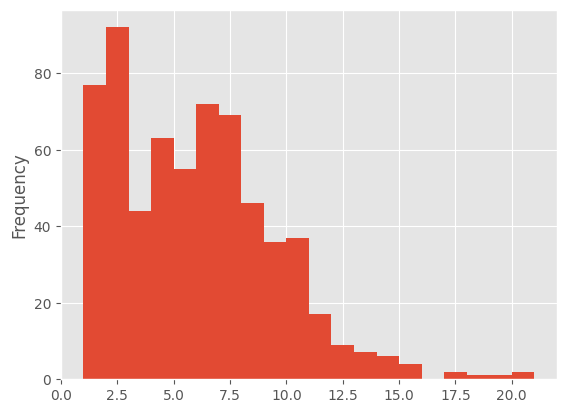

In [69]:
#Hipotes o tamnho das palavras em um testo qualquer, segue uma distribuição normal?
df['current word'].plot.hist(bins=20)

#Não é conclusivo se o tamanho das palavras seguem uma ditribuição normal, mesmo que tirando palavras de 1 e duas letras o grafico remanescente seja bem similar a uma distribuição normal.

<AxesSubplot:title={'center':'Frequencia de Palavras'}, xlabel='words'>

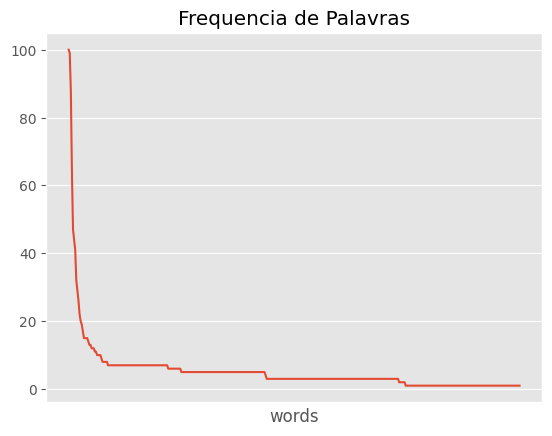

In [70]:
#Fato a frequencia de palavras em qualquer texto escrito pela humanidade em qualquer lingua tende a uma #distribuição de pareto. Vamos avaliar isso para notto data set
n = words_df.value_counts()
n.plot(title="Frequencia de Palavras", xticks=[])

# Podemos avaliar pelo grafico que elas tendem a uma distribuição de pareto. Infelizmente não conegui utilizar o dado de frequencia no modelo.

In [71]:
#Problema! Atualmente como esta iplementado o Power Reader tem sua velocideade definida por Palavras Por Minutos, que em uma pessoa "normal" esta na cassa dos 265 a 300. Com isso temos que o tempo para cada palavra é igual a 226ms. Vimos a cima que as palavras em um texto mudam de tamanho e algumas não são tão comuns como as outras. A pergunta é como fazer com que palavras maiores fiquem mais tempo e palavras menores fiquem menos tempo afim de conseguir uma média? Queremos criar um modelo que dado uma palavra nos dê uma porcentagem para ser multiplicada 

In [72]:
#Seperar Daados

df_st = df.copy()
x = df_st.drop(columns=['time'])
y = df_st['time']

print("Len x {} Len y {}".format(len(x),len(y)))

Len x 640 Len y 640


In [73]:
# Primeira solução possivel, regressão. Podemos tentar fazer com que cada numero nos de um tempo medio

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 200)

scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

regressor = LinearRegression()
regressor = regressor.fit(X_train, y_train)

ridge_regressor = BayesianRidge()
ridge_regressor.fit(X_train, y_train)

# Coeficient of every dimension in Multiplynomial Regression 
coeff_df = pd.DataFrame(regressor.coef_, x.columns, columns=['Coefficient'])
coeff_df 

,Coefficient
last word,-0.072454
current word,41.846954
next word,0.109710


In [85]:
y_pred = regressor.predict(X_test)
yDF = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
yDF

y_pred_ridge = ridge_regressor.predict(X_test)
yDFr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
yDFr, yDF

(         Actual   Predicted
 300  250.964396  245.330216
 45   212.360812  209.057246
 129  278.867970  281.611509
 141  183.155890  185.025886
 235  216.670813  221.107981
 ..          ...         ...
 384  271.863524  281.383815
 611  223.471692  221.128154
 252  324.453708  317.267706
 154  175.274976  185.062705
 490  222.545965  221.087808
 
 [160 rows x 2 columns],
          Actual   Predicted
 300  250.964396  245.330216
 45   212.360812  209.057246
 129  278.867970  281.611509
 141  183.155890  185.025886
 235  216.670813  221.107981
 ..          ...         ...
 384  271.863524  281.383815
 611  223.471692  221.128154
 252  324.453708  317.267706
 154  175.274976  185.062705
 490  222.545965  221.087808
 
 [160 rows x 2 columns])

In [84]:
cross_regressor = LinearRegression()
scores = cross_val_score(cross_regressor, X_test , y_test, cv = 10)
results = {"Linear Model| Accuracy" : scores.mean(), "uncertainty" : scores.std() * 2}
print(results)

#O Modelo Baysiano é melhor que a regressão linear pura
cross_ridge_regressor = BayesianRidge()
scores = cross_val_score(cross_ridge_regressor, X_test , y_test, cv = 10)
results = {"Bayesian| Accuracy" : scores.mean(), "uncertainty" : scores.std() * 2}
print(results)

{'Linear Model| Accuracy': 0.9643511633908289, 'uncertainty': 0.027171304380646563}
{'Bayesian| Accuracy': 0.9643501282208848, 'uncertainty': 0.027122017675439966}


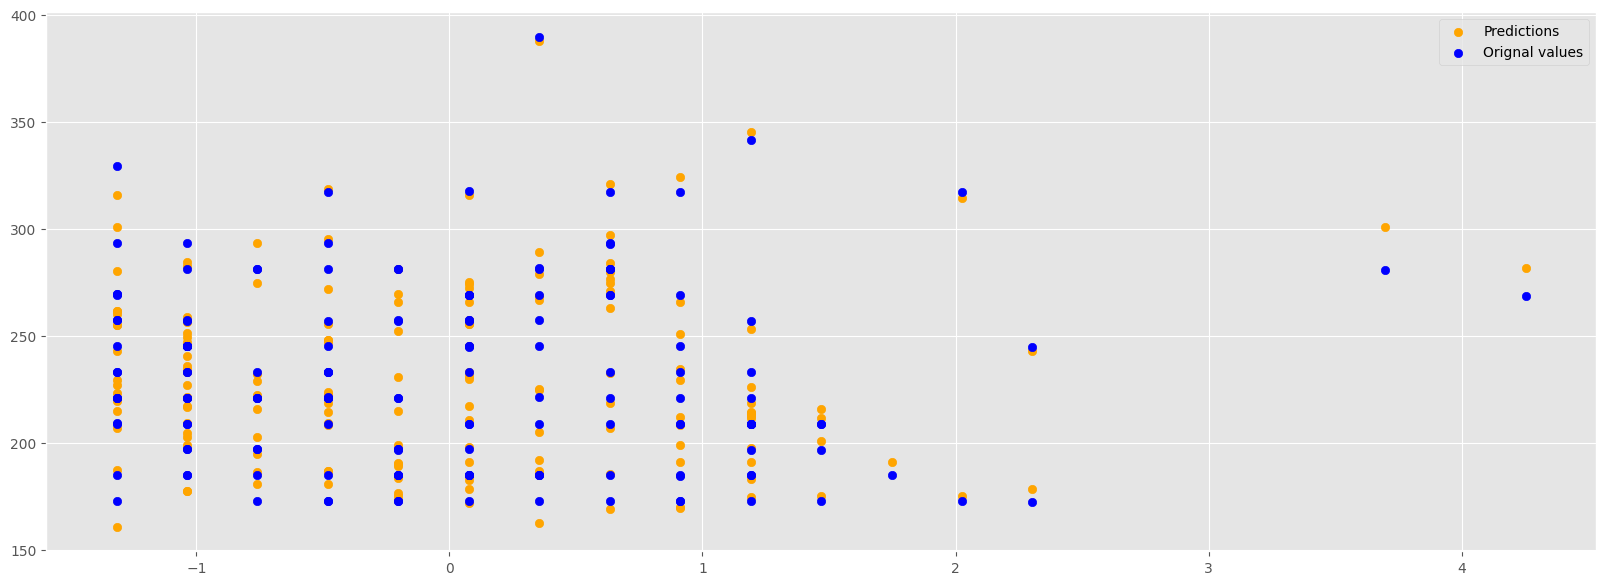

In [76]:
#Ploting predicted values and real values
plt.figure(figsize=(20,7))
plt.scatter(X_test[:,0], y_test , label= "Predictions", color="orange")
plt.scatter(X_test[:,0], y_pred,  label="Orignal values", color="blue")
plt.legend()
plt.show()

#Separation due to split in data

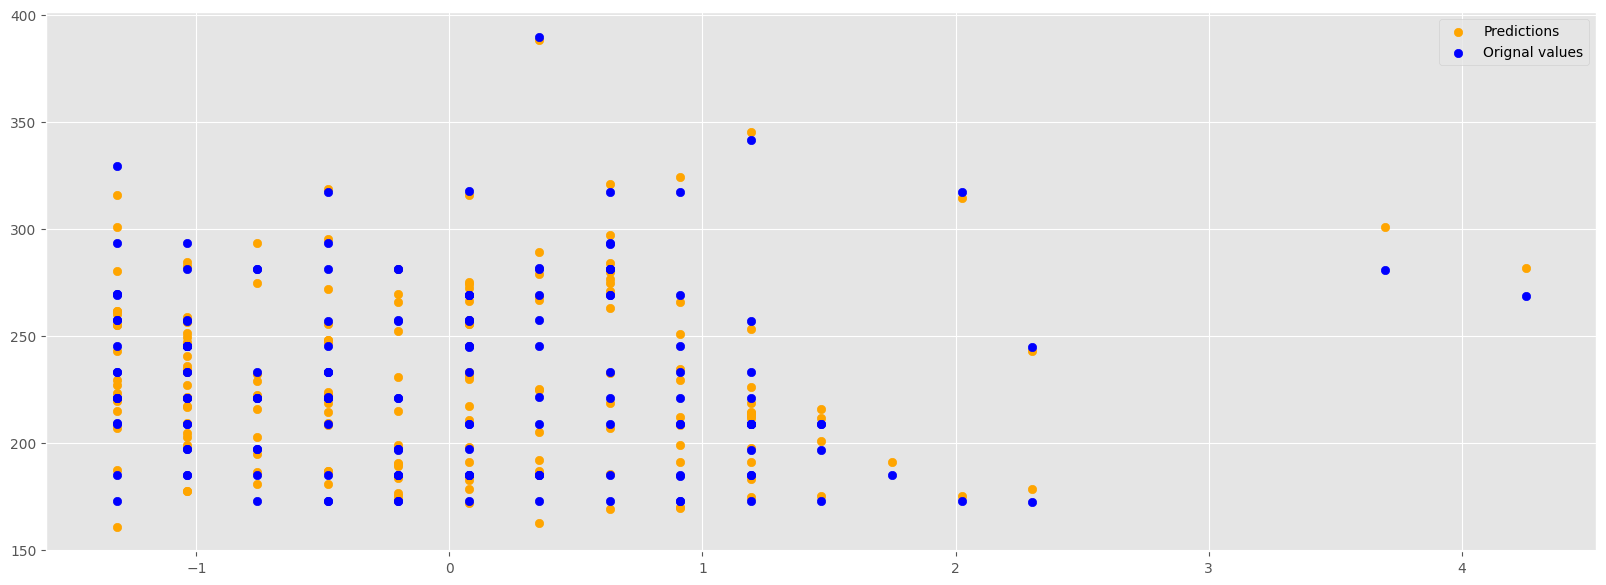

In [86]:
#Ploting predicted values and real values
plt.figure(figsize=(20,7))
plt.scatter(X_test[:,0], y_test , label= "Predictions", color="orange")
plt.scatter(X_test[:,0], y_pred_ridge,  label="Orignal values", color="blue")
plt.legend()
plt.show()

#Separation due to split in data

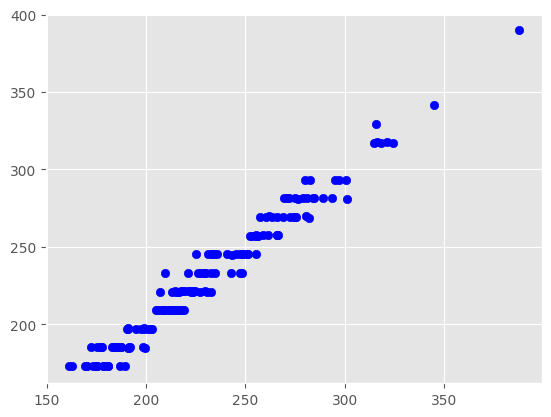

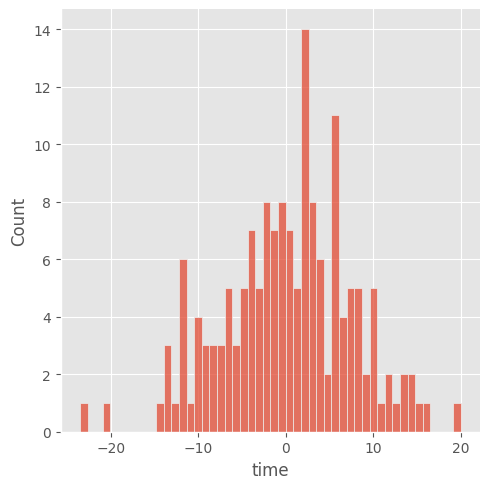

In [78]:
plt.scatter( y_test, y_pred, color='blue')
sns.displot((y_test-y_pred),bins=50)

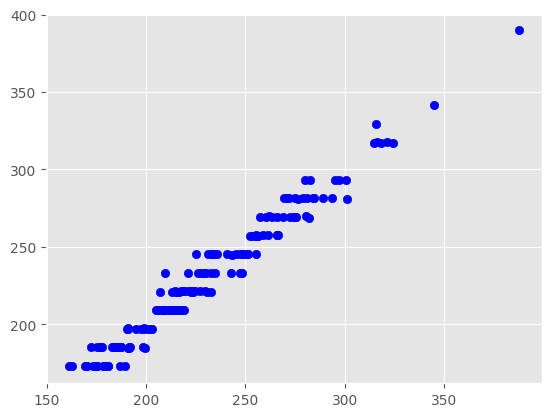

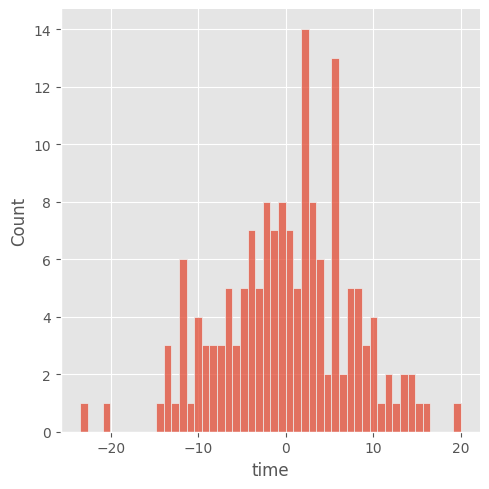

In [87]:
plt.scatter( y_test, y_pred_ridge, color='blue')
sns.displot((y_test-y_pred_ridge),bins=50)

In [ ]:
# Mesmo os modelos sendo muito similares, ainda acho a regresão por Bayes melhor para um futuro projeto. Outra coisa interessante tambem seria add 